<a href="https://colab.research.google.com/github/hansbrunner/clinical_trials-analysis/blob/main/Veterans_Administration_Lung_Cancer_Trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
This is a simple exercise in survival analysis using the Veterans Administration Lung Cancer Trial dataset.
In this analysis, I applied Kaplan-Meier survival curves, Cox Proportional Hazards model, and the Log-rank test to evaluate the impact of different
variables on patient survival. The results indicate that treatment does not significantly influence survival.
However, cell type plays a crucial role, with adenocarcinoma and small cell carcinoma associated with higher mortality rates compared to other cell types.
Subgroup analysis could be interesting, but I have not done this due to the relative small sample size.
"""

In [144]:
# Import the Veterans' Lung Cancer dataset from sksurv
import pandas as pd
import sksurv
data, endpoints = sksurv.datasets.load_veterans_lung_cancer() # Returns dataframe with measurement and survival information

# Merge data
endpoints_df = pd.DataFrame({
    'Survival_in_days': [entry[1] for entry in endpoints],  # Extract survival time
    'Status': [entry[0] for entry in endpoints]  # Extract event status
})

df = pd.concat([data, endpoints_df], axis=1)
# Convert 'Prior_therapy' from string to boolean
df['Prior_therapy'] = df['Prior_therapy'].astype(str).map({'yes': True, 'no': False})
df['Treatment'] = df['Treatment'].astype(str).map({'standard': 0, 'test': 1})

In [145]:
# Summarize key demographic variables by treatment group
summary_table = df.groupby('Treatment').agg({
    'Age_in_years': ['mean', 'std'],
    'Karnofsky_score': ['mean', 'std'],  # Karnofsky performance score
    'Months_from_Diagnosis': ['mean', 'std'],  # Time from diagnosis to treatment
    'Prior_therapy': ['sum', 'count'],  # Count of patients with prior therapy
    'Survival_in_days': ['mean', 'std'],  # Mean survival time
    'Status': ['sum', 'count']  # Total deaths (sum of Status)
})

# Display the summary table
#print(summary_table)
styled_table = summary_table.style.format(precision=2)  # Angiver 2 decimaler
styled_table.set_caption("Summary Statistics by Treatment")  # Tilføj en titel

# Vis tabellen
styled_table

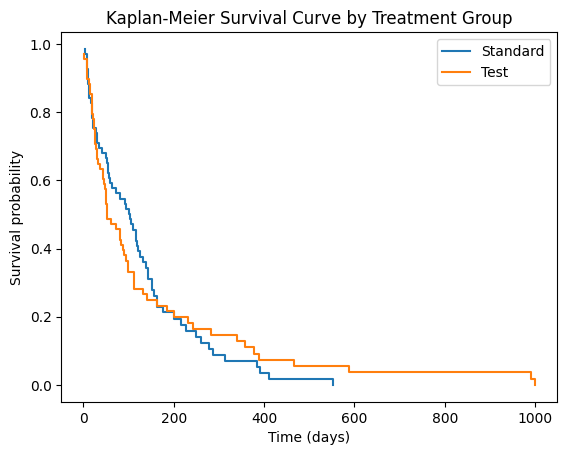

In [146]:
# Kaplan-Meier survival analysis
from sksurv.nonparametric import kaplan_meier_estimator
import matplotlib.pyplot as plt

# Split data into treatment groups
group_standard = df[df['Treatment'] == 0]  # Treatment A
group_test = df[df['Treatment'] == 1]  # Treatment B

# Kaplan-Meier estimate for Treatment A
time_a, survival_prob_a = kaplan_meier_estimator(group_standard['Status'], group_standard['Survival_in_days'])

# Kaplan-Meier estimate for Treatment B
time_b, survival_prob_b = kaplan_meier_estimator(group_test['Status'], group_test['Survival_in_days'])

# Plot Kaplan-Meier curves
plt.step(time_a, survival_prob_a, where="post", label="Standard")
plt.step(time_b, survival_prob_b, where="post", label="Test")
plt.ylabel("Survival probability")
plt.xlabel("Time (days)")
plt.legend()
plt.title("Kaplan-Meier Survival Curve by Treatment Group")
plt.show()


In [147]:
# Cox proportional hazards
from sksurv.linear_model import CoxPHSurvivalAnalysis
from lifelines import CoxPHFitter # prøv med denne i stedet - kan give summary statistics
import numpy as np

# Preprocess for Cox regression
tmp = df[['Survival_in_days', 'Status', 'Age_in_years', 'Treatment', 'Karnofsky_score',
             'Prior_therapy']]

# Fit the Cox proportional hazards model
cox_model = CoxPHFitter()
cox_model.fit(tmp, duration_col = 'Survival_in_days', event_col = 'Status')

cox_model.print_summary()

<lifelines.CoxPHFitter: fitted with 137 total observations, 9 right-censored observations>
             duration col = 'Survival_in_days'
                event col = 'Status'
      baseline estimation = breslow
   number of observations = 137
number of events observed = 128
   partial log-likelihood = -483.83
         time fit was run = 2024-09-20 12:39:45 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
Age_in_years     -0.00       1.00       0.01            -0.02             0.01                 0.98                 1.01
Treatment         0.19       1.21       0.19            -0.17             0.56                 0.84                 1.75
Karnofsky_score  -0.03       0.97       0.01            -0.04            -0.02                 0.96                 0.98
Prior_therapy    -0.06       0.94       0.20            -0.46             0.34                 0.63                 1.40

                  cmp to     z      p   -log2(p)
covariate                                       
Age_in_years        0.00 -0.44   0.66       0.60
Treatment           0.00  1.04   0.30       1.75
Karnofsky_score     0.00 -6.52 <0.005      33.76
Prior_therapy       0.00 -0.30   0.76       0.39
---
Concordance = 0.71
Partial AIC = 975.67
log-likelihood ratio test = 43.23 on 4 df
-log2(p) of ll-ratio test = 26.69

In [148]:
from lifelines.statistics import logrank_test
# Perform the log-rank test
results = logrank_test(
    group_standard['Survival_in_days'], group_test['Survival_in_days'],  # Survival time
    group_standard['Status'], group_test['Status']  # Event occurred (1 = death)
)

# Print the results of the log-rank test
print(results.summary)

   test_statistic         p  -log2(p)
0        0.008227  0.927727  0.108227


<ipython-input-149-52878bafd76a>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for ctype, tmp in df.groupby("Celltype"):


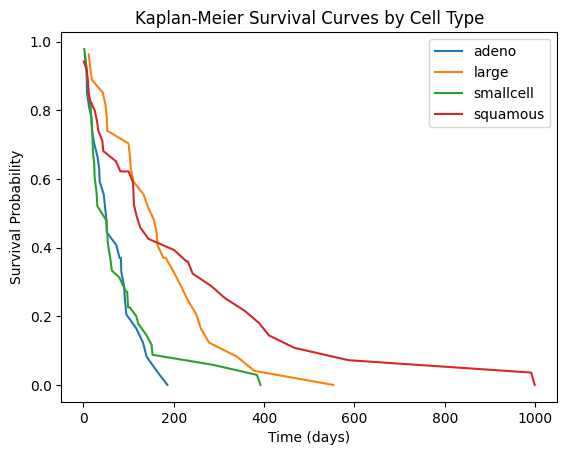

In [149]:
# Kaplan-Meier by cell type

# Plot survival curves for each cell type
for ctype, tmp in df.groupby("Celltype"):

    time, survival_prob = kaplan_meier_estimator(tmp['Status'], tmp['Survival_in_days'])
    plt.plot(time, survival_prob, label=ctype)

plt.title("Kaplan-Meier Survival Curves by Cell Type")
plt.xlabel("Time (days)")
plt.ylabel("Survival Probability")
plt.legend()
plt.show()

In [150]:
# Incorporate cell types
new_df = df.copy()
# Turn categorical celltype into dummy variables
new_df = pd.get_dummies(new_df, columns=['Celltype'], drop_first=False)
tmp = new_df[['Survival_in_days', 'Status', 'Age_in_years', 'Treatment', 'Karnofsky_score',
             'Prior_therapy', 'Celltype_adeno', 'Celltype_smallcell', 'Celltype_squamous']]

# Fit the Cox proportional hazards model
cox_model = CoxPHFitter()
cox_model.fit(tmp, duration_col = 'Survival_in_days', event_col = 'Status')

cox_model.print_summary()





<lifelines.CoxPHFitter: fitted with 137 total observations, 9 right-censored observations>
             duration col = 'Survival_in_days'
                event col = 'Status'
      baseline estimation = breslow
   number of observations = 137
number of events observed = 128
   partial log-likelihood = -474.40
         time fit was run = 2024-09-20 12:39:58 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
Age_in_years        -0.01       0.99       0.01            -0.03             0.01                 0.97                 1.01
Treatment            0.29       1.34       0.21            -0.11             0.70                 0.90                 2.01
Karnofsky_score     -0.03       0.97       0.01            -0.04            -0.02                 0.96                 0.98
Prior_therapy        0.07       1.08       0.21            -0.33             0.48                 0.72                 1.61
Celltype_adeno       0.79       2.21       0.30             0.20             1.39                 1.22                 4.00
Celltype_smallcell   0.46       1.59       0.26            -0.06             0.98                 0.95                 2.66
Celltype_squamous   -0.40       0.67       0.28            -0.96             0.15                 0.38                 1.16

                     cmp to     z      p   -log2(p)
covariate                                          
Age_in_years           0.00 -0.94   0.35       1.53
Treatment              0.00  1.43   0.15       2.70
Karnofsky_score        0.00 -6.04 <0.005      29.24
Prior_therapy          0.00  0.35   0.73       0.46
Celltype_adeno         0.00  2.63   0.01       6.86
Celltype_smallcell     0.00  1.75   0.08       3.63
Celltype_squamous      0.00 -1.42   0.16       2.69
---
Concordance = 0.74
Partial AIC = 962.79
log-likelihood ratio test = 62.10 on 7 df
-log2(p) of ll-ratio test = 34.02